In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm
import pandas as pd

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Perform time evolution </h1>

In [2]:
def bs_evolution(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, delta_x, use_WW_approx = True, print_nb_modes = False):
    
    #quantization of the modes by keeping only a portion of them
    #omega_tab_p = np.linspace(0, omega_max , nb_omega)
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    #keep only a portion of the modes 
    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)

    if print_nb_modes:
        print("Number of modes: ", n_modes)
    
    #create the Hamiltonian
    dim_subspace = n_modes * (2*n_modes + 1) + 2*n_modes
    if print_nb_modes:
        print("Dimension of the subspace: ", dim_subspace)

    
    print("Generating the Hamiltonian...")
    #tab with the coupling parameters
    g_tab = np.zeros(n_modes, dtype=complex)
    for i in range(n_modes):
            if use_WW_approx:
                g_tab[i] = g_0*np.sqrt(omega_A/L)*1j
            else:
                g_tab[i] = g_0*np.sqrt(omega_tab[i]/L)*1j #in my case, g is independant of the atom index


    #now define the Hamiltonian
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)
    index = 0 #dummy way to do it but I'm struggling to find a direct mapping

    ###Diagonal elements

    #diagonal elements with two photons in the horizontal direction
    for i in range(n_modes):
        for j in range(i, n_modes):
            H_matrix[index, index] = omega_tab[i] + omega_tab[j]
            index += 1

    #diagonal elements with two photons in the vertical direction
    for i in range(n_modes):
        for j in range(i, n_modes):
            H_matrix[index, index] = omega_tab[i] + omega_tab[j]
            index += 1
            
    #diagonal elements with two photons in distinct directions
    for i in range(n_modes**2):
        H_matrix[index,index] = omega_tab[int(i//n_modes)] + omega_tab[int(i%n_modes)]
        index += 1

    #diagonal elements with one horizontal photon and one excited atom
    for i in range(n_modes):
        H_matrix[index,index] = omega_tab[i] + omega_A
        index += 1

    #diagonal elements with one vertical photon and the atom
    for i in range(n_modes):
        H_matrix[index,index] = omega_tab[i] + omega_A
        index += 1

    ## Off diagonal elements

    #|2,0,0> <-> |1,0,1>
    dummy_index_0 = 0
    for i in range(n_modes):
        for j in range(i, n_modes):
            dummy_index_1 = n_modes*(2*n_modes + 1)
            for k in range(n_modes):
                if k == i:
                    if i == j:
                        H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[j])
                        H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                    else:
                        H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[j])
                        H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                if k == j:
                    if i == j:
                        H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[i])
                        H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                    else:
                        H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i])
                        H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])

                dummy_index_1 += 1
            dummy_index_0 += 1

    #|0,2,0> <-> |0,1,1>
    dummy_index_0 = n_modes*(n_modes + 1)//2
    for i in range(n_modes):
        for j in range(i, n_modes):
            dummy_index_1 = n_modes*(2*n_modes + 1) + n_modes
            for k in range(n_modes):
                if k == i:
                    if i == j:
                        H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[j])
                        H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                    else:
                        H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[j])
                        H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                if k == j:
                    if i == j:
                        H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[i])
                        H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                    else:
                        H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i])
                        H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])

                dummy_index_1 += 1
            dummy_index_0 += 1

    #|1,1,0> <-> |1,0,1>
    dummy_index_0 = n_modes*(n_modes + 1)
    for i in range(n_modes):
        for j in range(n_modes):
            dummy_index_1 = n_modes*(2*n_modes + 1) 
            for k in range(n_modes):
                if k == i:
                    H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[j])
                    H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                if k == j:
                        H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i])
                        H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                                
                dummy_index_1 += 1
            dummy_index_0 += 1
        
    #|1,1,0> <-> |0,1,1>
    dummy_index_0 = n_modes*(n_modes + 1)
    for i in range(n_modes):
        for j in range(n_modes):
            dummy_index_1 = n_modes*(2*n_modes + 1) + n_modes
            for k in range(n_modes):
                if k == i:
                    H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[j])
                    H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                if k == j:
                    H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i])
                    H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                                
                dummy_index_1 += 1
            dummy_index_0 += 1

    H = qt.Qobj(H_matrix)

    #hermicity check
    if not H.isherm:
        print("Warning: the Hamiltonian is not hermitian")
        return None
    

    #also get the free Hamiltonian
    H_free = qt.Qobj(np.diag(np.diag(H_matrix)))

    print("Preparing the initial state...")
    ##Now prepare the initial state
    x_0_a = x_0
    x_0_b = x_0 + delta_x

    init_state = 0
    for i in range(n_modes**2):
        k_a = k_tab[int(i//n_modes)]
        k_b = k_tab[int(i%n_modes)]
        if k_a > 0 and k_b > 0:
            c_a = np.exp(-0.5*sigma**2*(k_a - omega_0)**2 -1j * k_a * x_0_a)
            c_b = np.exp(-0.5*sigma**2*(k_b - omega_0)**2 -1j * k_b * x_0_b)
            init_state += c_a * c_b * qt.basis(dim_subspace, n_modes*(n_modes+1) + i)

    init_state = init_state.unit()


    print("Conducting time evolution...")
    ##Conduct time evolution
    n_step = int(T/dt)
    times = np.linspace(0, T, n_step)
    result = qt.sesolve(H, init_state, times, options={"nsteps":10000, "progress_bar": True, "store_states": True})
    state_list = result.states

    print("Conducting free evolution...")
    #also get the free evolution of the initial state
    result_free = qt.sesolve(H_free, init_state, times, options={"nsteps":10000, "store_states": True, "progress_bar": True})
    state_list_free = result_free.states
    print("Done.")

    return state_list, state_list_free, k_tab, times


In [7]:
L = 10*pi
T = L/2
dt = 0.1

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 1
omega_A = 3
omega_0 = 6.6
omega_max = 10

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4
delta_x = sigma

#check some parameters
gamma = g_0**2 * omega_A
print("50% Reflectivity for omega_0_m = ", omega_A - gamma, " and omega_0_p = ", omega_A + gamma)

50% Reflectivity for omega_0_m =  0  and omega_0_p =  6


In [8]:

#conduct the evolution
state_list, state_list_free, k_tab, times = bs_evolution(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, delta_x, use_WW_approx = True, print_nb_modes = True)

Number of modes:  101
Dimension of the subspace:  20705
Generating the Hamiltonian...
Preparing the initial state...
Conducting time evolution...
10.3%. Run time:  13.40s. Est. time left: 00:00:01:57
20.5%. Run time:  25.62s. Est. time left: 00:00:01:39
30.1%. Run time:  37.02s. Est. time left: 00:00:01:25
40.4%. Run time:  51.69s. Est. time left: 00:00:01:16
50.0%. Run time:  65.80s. Est. time left: 00:00:01:05
60.3%. Run time:  81.08s. Est. time left: 00:00:00:53
70.5%. Run time:  95.84s. Est. time left: 00:00:00:40
80.1%. Run time: 107.17s. Est. time left: 00:00:00:26
90.4%. Run time: 119.74s. Est. time left: 00:00:00:12
100.0%. Run time: 131.37s. Est. time left: 00:00:00:00
Total run time: 131.38s
Conducting free evolution...
10.3%. Run time:  11.75s. Est. time left: 00:00:01:42
20.5%. Run time:  22.23s. Est. time left: 00:00:01:26
30.1%. Run time:  32.54s. Est. time left: 00:00:01:15
40.4%. Run time:  43.33s. Est. time left: 00:00:01:03
50.0%. Run time:  53.75s. Est. time left: 00

In [9]:
nb_pts_time = len(times)
n_modes = len(k_tab)
n_modes * (2*n_modes + 1) + 2*n_modes

overlap = np.zeros(nb_pts_time)
atom_occupation = np.zeros(nb_pts_time)

for i in tqdm(range(nb_pts_time)):
    current_state = state_list[i]
    current_state_free = state_list_free[i]
   
    overlap[i] = np.abs(current_state.dag() * current_state_free)**2
    atom_occupation[i] = 0
    for j in range(n_modes):
        atom_occupation[i] += np.abs(current_state[n_modes*(2*n_modes + 1) + j][0])**2

  0%|          | 0/157 [00:00<?, ?it/s]

Final overlap with the free evolution:  0.17289978934571734
Theory value:  0.1967346701436833


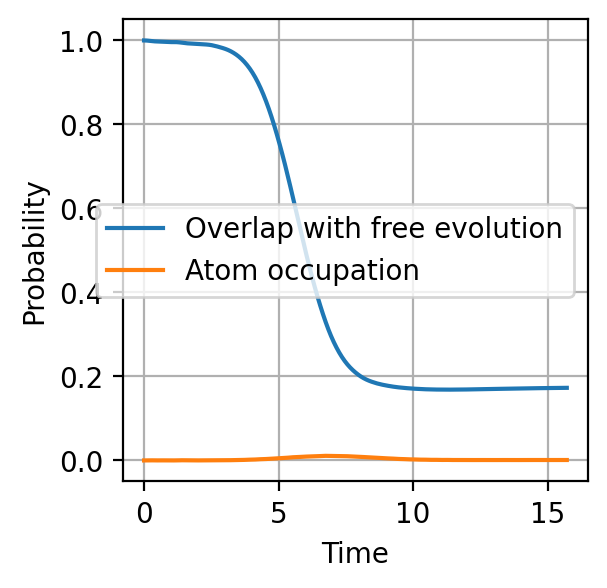

In [12]:
print("Final overlap with the free evolution: ", overlap[-1])
print("Theory value: ", 0.5*(1- np.exp(- (delta_x**2) / (2*sigma**2))))

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(times, overlap, label="Overlap with free evolution")
ax.plot(times, atom_occupation, label="Atom occupation")
ax.set_xlabel("Time")
ax.set_ylabel("Probability")
ax.grid()
ax.legend()
plt.show()

<h1> Reproduce a HOM effect </h1>

In [13]:
L = 5*pi
T = L/2
dt = 0.1

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 1
omega_A = 1
omega_0 = 2
omega_max = 5

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4

#prepare several values of delta_x
nb_pts_x = 9
delta_x_tab = np.linspace(-3*sigma, 3*sigma, nb_pts_x)
final_overlap_free_tab = np.zeros(nb_pts_x)

for i in tqdm(range(nb_pts_x)):
    delta_x = delta_x_tab[i]
    state_list, state_list_free, k_tab, times = bs_evolution(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, delta_x, use_WW_approx = True, print_nb_modes = True)
    final_overlap_free_tab[i] = np.abs(state_list_free[-1].dag() * state_list[-1])**2

  0%|          | 0/9 [00:00<?, ?it/s]

Number of modes:  25
Dimension of the subspace:  1325
Generating the Hamiltonian...
Preparing the initial state...
Conducting time evolution...
10.4%. Run time:   0.03s. Est. time left: 00:00:00:00
20.8%. Run time:   0.05s. Est. time left: 00:00:00:00
31.2%. Run time:   0.08s. Est. time left: 00:00:00:00
40.3%. Run time:   0.10s. Est. time left: 00:00:00:00
50.6%. Run time:   0.12s. Est. time left: 00:00:00:00
61.0%. Run time:   0.15s. Est. time left: 00:00:00:00
70.1%. Run time:   0.21s. Est. time left: 00:00:00:00
80.5%. Run time:   0.24s. Est. time left: 00:00:00:00
90.9%. Run time:   0.26s. Est. time left: 00:00:00:00
100.0%. Run time:   0.29s. Est. time left: 00:00:00:00
Total run time:   0.29s
Conducting free evolution...
10.4%. Run time:   0.06s. Est. time left: 00:00:00:00
20.8%. Run time:   0.11s. Est. time left: 00:00:00:00
31.2%. Run time:   0.15s. Est. time left: 00:00:00:00
40.3%. Run time:   0.19s. Est. time left: 00:00:00:00
50.6%. Run time:   0.22s. Est. time left: 00:0

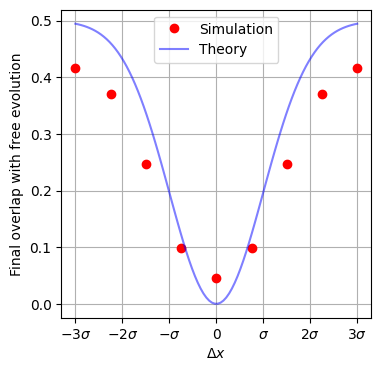

In [14]:
delta_x_theory = np.linspace(-3*sigma, 3*sigma, 100)
overlap_theory = 0.5*(1- np.exp(- (delta_x_theory**2) / (2*sigma**2)))

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(delta_x_tab, final_overlap_free_tab, 'o', label="Simulation", color='red')
ax.plot(delta_x_theory, overlap_theory, label="Theory", color="blue", alpha=0.5)
ax.set_xlabel(r"$\Delta x$")
ax.set_ylabel("Final overlap with free evolution")
ax.set_xticks(np.array([-3,-2, -1, 0, 1, 2,3])*sigma)
ax.set_xticklabels([r"$-3\sigma$", r"$-2\sigma$", r"$-\sigma$", "0", r"$\sigma$", r"$2\sigma$", r"$3\sigma$"])
ax.grid()
ax.legend()
plt.show()